/var/folders/rd/thp_lwbs14n9hkhhc4r29lfw0000gn/T/ipykernel_7067/3611714096.py:44: UserWarning: loadtxt: input contained no data: "./ShuEnergies/v0b74.txt"
  evec = np.loadtxt(path)
/var/folders/rd/thp_lwbs14n9hkhhc4r29lfw0000gn/T/ipykernel_7067/3611714096.py:44: UserWarning: loadtxt: input contained no data: "./ShuEnergies/v0b75.txt"
  evec = np.loadtxt(path)
/var/folders/rd/thp_lwbs14n9hkhhc4r29lfw0000gn/T/ipykernel_7067/3611714096.py:44: UserWarning: loadtxt: input contained no data: "./ShuEnergies/v0b76.txt"
  evec = np.loadtxt(path)
/var/folders/rd/thp_lwbs14n9hkhhc4r29lfw0000gn/T/ipykernel_7067/3611714096.py:44: UserWarning: loadtxt: input contained no data: "./ShuEnergies/v0b77.txt"
  evec = np.loadtxt(path)
/var/folders/rd/thp_lwbs14n9hkhhc4r29lfw0000gn/T/ipykernel_7067/3611714096.py:44: UserWarning: loadtxt: input contained no data: "./ShuEnergies/v0b78.txt"
  evec = np.loadtxt(path)
/var/folders/rd/thp_lwbs14n9hkhhc4r29lfw0000gn/T/ipykernel_7067/3611714096.py:44: UserWarning: 

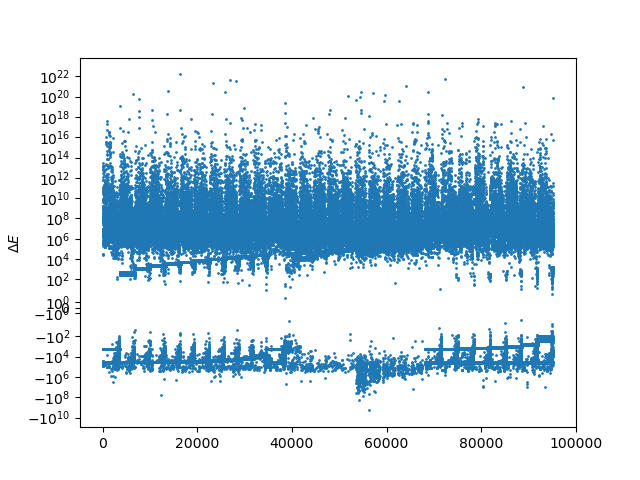

In [6]:
import numpy as np
import os
import matplotlib.pyplot as plt
import re
import math
import glob
import pandas as pd

class SplitArray:
    def __init__(self, array, m):
        self.array = array
        self.m = m
        self.n = len(array)
        self.chunk_size = self.n // m
        self.remainder = self.n % m

    def __getitem__(self, index):
        if index >= self.m or index < -self.m:
            raise IndexError("Split index out of range")

        if index < 0:
            index += self.m

        start = index * self.chunk_size + min(index, self.remainder)
        end = start + self.chunk_size
        if index < self.remainder:
            end += 1
        return self.array[start:end]

    def __len__(self):
        return self.m

cs = math.sqrt(3.36) * 100
bvec = np.logspace(9, 17, 80)
Nv = 30
vvec = np.logspace(np.log10(cs / 10), np.log10(cs * 5), Nv)

folder = './ShuEnergies'
energies = sorted(os.listdir(folder))
Efinal = []

for e in energies:
    path = os.path.join(folder, e)
    evec = np.loadtxt(path)

    pattern = r"v(\d+)b(\d+)"

    match = re.search(pattern, e)

    if match:
        v_index = int(match.group(1))
        b_index = int(match.group(2))
    else:
        print("No match found")

    v0 = vvec[v_index]

    if evec.size == 0:
            continue

    if evec.size == 1:
        Efinal.append([evec])
        continue

    Efinal.append(evec)

Efinal = np.concatenate(Efinal)

plt.clf()
plt.ylabel(r'$\Delta E$')
plt.scatter(range(len(Efinal)), Efinal, s=1)
plt.yscale('symlog')
plt.show()

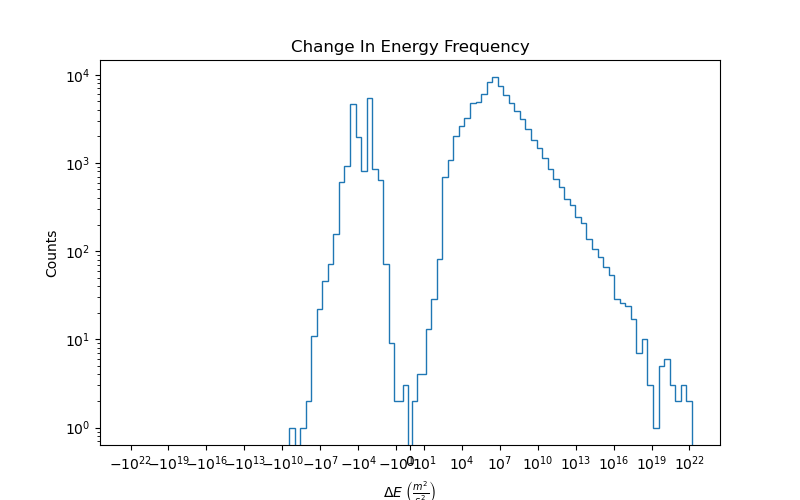

In [7]:
%matplotlib widget

def log_histogram(data, bins):
    data = np.array(data)
    positive_data = data[data > 0]
    negative_data = -data[data < 0]

    min_val = min(positive_data.min(), negative_data.min())
    max_val = max(positive_data.max(), negative_data.max())

    log_bins = np.logspace(np.log10(min_val), np.log10(max_val), num=bins+1)

    neg_bins = -log_bins[::-1]
    all_bins = np.concatenate([neg_bins, [0], log_bins])

    counts, edges = np.histogram(data, bins=all_bins)

    plt.figure(figsize=(8, 5))
    plt.hist(data, bins=all_bins, histtype='step')

log_histogram(Efinal, bins=50)
plt.xscale('symlog', linthresh=1e1)
plt.yscale('log')
plt.xlabel(r'$\Delta E$ $\left(\frac{m^2}{s^2}\right)$')
plt.ylabel('Counts')
plt.title('Change In Energy Frequency')
plt.show()

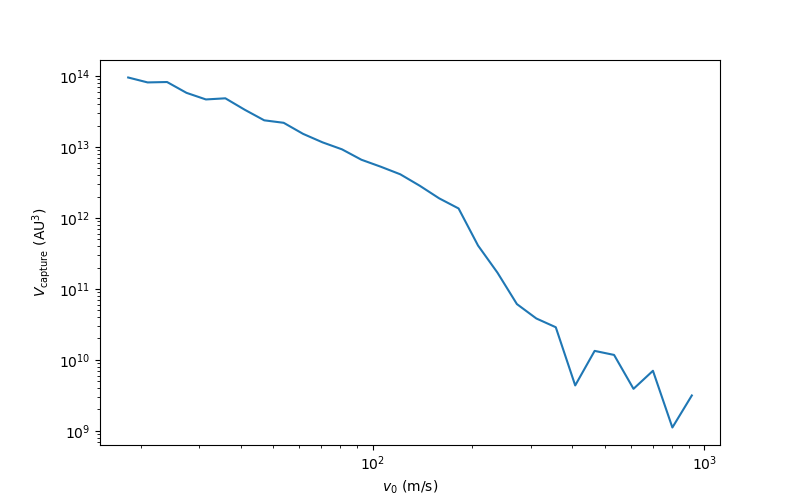

In [12]:
import pandas as pd
import os
import numpy as np
import fast_histogram as fh
import matplotlib.pyplot as plt
import re
import math

plt.clf()
cs = math.sqrt(3.36) * 100
bvec = np.logspace(9, 17, 80)
Nv = 30
vvec = np.logspace(np.log10(cs / 10), np.log10(cs * 5), Nv)
tf = 1.0829*10.0**13 #s

V = {}

def captureVol(dir_path):
    V = {}
    bmax = 0

    dir_re  = re.compile(r"ShuEnergies$")
    file_re = re.compile(r"v(\d+)b(\d+)\.txt")

    def sort_key(fname):
        m = file_re.match(fname)
        if not m:
            return (1e9, 1e9)
        v_i, b_i = map(int, m.groups())
        return (v_i, b_i)

    dirname = os.path.basename(dir_path.rstrip('/'))
    
    '''
    dm = dir_re.match(dirname)

    if not dm:
        raise ValueError(f"Directory name {dirname!r} does not match dataShu<digits>")
    
    folder_index = int(dm.group(1))
    '''
    
    for v in vvec:
        V[str(v)] = []

    bvec = bvec = np.logspace(9, 17, 80)

    for fname in sorted(os.listdir(dir_path), key=sort_key):
        if not fname.endswith('.txt'):
            continue

        fpath = os.path.join(dir_path, fname)
        if os.path.getsize(fpath) == 0:
            continue
        data  = np.loadtxt(fpath)
        
        fm = file_re.match(fname)
        if not fm:
            print(f"  skipping unexpected file {fname!r}")
            continue

        v_index = int(fm.group(1))
        b_index = int(fm.group(2))

        Ncapt = 0

        if data.size == 0:
                continue
        if data.size == 1:
            if data<0:
                Ncapt += 1
            else:
                continue
        if data.size > 1:
            for e in data:
                if e < 0 :
                    Ncapt += 1
                else:
                    continue
        
        Vcapture = np.pi*Ncapt*(bvec[b_index+1]**2-bvec[b_index]**2)*vvec[v_index]*tf/50
        V[f'{vvec[v_index]}'].append(Vcapture)

    Vcapture = []
    for v in V.keys():
        Vtot = np.sum(np.array(V[f'{v}']))
        Vcapture.append([f'{v}', Vtot])

    v0 = np.array([float(Vcapture[i][0]) for i in range(len(Vcapture))])
    Vvol = np.array([Vcapture[i][1]/((1.496e11)**3) for i in range(len(Vcapture))])

    plt.plot(v0, Vvol)
    plt.yscale('log')
    plt.xscale('log')
    plt.xlabel(r'$v_0$ (m/s)')
    plt.ylabel(r'$V_{\mathrm{capture}}$ (AU$^3$)')
        

captureVol('./ShuEnergies')

plt.show()
